In [20]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.animation import FuncAnimation

import os
import glob
import pandas as pd
import json
from dotenv import load_dotenv
from functools import partial

In [21]:
plt.rcParams['animation.ffmpeg_path'] = '/cluster/home/vogtva/miniconda3/envs/psc/bin/ffmpeg'

In [22]:
def get_db(data_dir):
    json_files = glob.glob(os.path.join(data_dir, "*.json"))
    data_list = []

    # Iterate through the JSON files and read them
    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
            data_list.append(data)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data_list)
    return df

In [23]:
model = "bruss"
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
output_dir = os.path.join(output_dir, model)
os.makedirs(output_dir, exist_ok=True)
df0 = get_db(os.path.join(data_dir, model))
df0['run_id'].unique()

array([nan, 'vary_ab_exp', 'vary_a_b', 'vary_sources', 'vary_du_dv',
       'bruss_blowup'], dtype=object)

In [24]:
df = df0.copy()
df = df[(df["run_id"] == 'vary_a_b')]
df

,model,A,B,Nx,dx,Nt,dt,Du,Dv,sigma_ic,random_seed,n_snapshots,filename,run_id,num_sources
3,bruss,15.0,30.0,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/8243e11a-dd...,vary_a_b,NaN
5,bruss,1.0,1.5,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/a566f878-b8...,vary_a_b,NaN
7,bruss,3.0,9.0,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/75b10f93-0e...,vary_a_b,NaN
14,bruss,1.0,0.5,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/d8bcdf26-02...,vary_a_b,NaN
18,bruss,3.0,1.5,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/795e8fe3-51...,vary_a_b,NaN
20,bruss,11.0,11.0,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/5e859158-4a...,vary_a_b,NaN
22,bruss,1.0,2.5,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/a1ca7634-ca...,vary_a_b,NaN
26,bruss,3.0,4.5,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/e1ebf832-3d...,vary_a_b,NaN
27,bruss,11.0,22.0,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/fb522f5c-01...,vary_a_b,NaN
30,bruss,13.0,26.0,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/8aa2e490-cb...,vary_a_b,NaN


In [25]:
def ab_grid(
    df, component_idx=0, frame=-1, sigdigits=2, var1="A", var2="B", file="", an=False
):
    if len(df) == 0:
        return None

    df = df.sort_values(by=[var1, var2])
    A_count = len(df[var1].unique())
    print(A_count)
    B_count = int(len(df) / A_count)
    print(B_count)
    fig = plt.figure(figsize=(15, 12))
    grid = ImageGrid(fig, 111, nrows_ncols=(A_count, B_count), axes_pad=(0.1, 0.3))

    ims = []

    for i, row in df.iterrows():
        ds = nc.Dataset(row["filename"])

        data = ds.variables["data"][:]
        ims.append((row, data[0, frame, :, component_idx::2]))

    for ax, (row, im) in zip(grid, ims):
        ax.set_title(
            f"{var1}={row[var1]:.{sigdigits}f}\n{var2} = {row[var2]:.{sigdigits}f}",
            fontsize=6,
        )
        ax.imshow(im, cmap="viridis")
        ax.set_aspect("equal")
        ax.axis("off")
    row = df.iloc[0]
    if frame == -1:
        time = row["dt"] * row["Nt"]
    else:
        time = row["dt"] * frame * row["Nt"] / row["n_snapshots"]
    fig.suptitle(
        f"{row['model'].capitalize()}, Nx={row['Nx']}, dx={row['dx']}, dt={row['dt']}, T={time:.2f}",
        fontsize=16,
    )

    if file != "":
        plt.savefig(file, dpi=100)
    if not an:
        plt.show()
    return grid


In [26]:
def ab_grid_animation(
    df, component_idx=0, sigdigits=2, var1="A", var2="B", file="", fps=10
):
    if len(df) == 0:
        return None

    df = df.sort_values(by=[var1, var2])
    A_count = len(df[var1].unique())
    B_count = int(len(df) / A_count)

    fig = plt.figure(figsize=(15, 12))
    grid = ImageGrid(fig, 111, nrows_ncols=(A_count, B_count), axes_pad=(0.1, 0.3))
    ims = []

    # Preload data and calculate global min/max for normalization
    global_min, global_max = float("inf"), float("-inf")
    for i, row in df.iterrows():
        ds = nc.Dataset(row["filename"])
        data = ds.variables["data"][:]
        ims.append((row, data))
        global_min = min(global_min, data[0, :, :, component_idx::2].min())
        global_max = max(global_max, data[0, :, :, component_idx::2].max())

    # Normalization parameters for consistent color mapping
    norm = plt.Normalize(vmin=global_min, vmax=global_max)

    def update(frame):
        fig.clear()
        grid = ImageGrid(fig, 111, nrows_ncols=(A_count, B_count), axes_pad=(0.1, 0.3))

        for ax, (row, data) in zip(grid, ims):
            im = data[0, frame, :, component_idx::2]
            ax.set_title(
                f"{var1}={row[var1]:.{sigdigits}f}\n{var2} = {row[var2]:.{sigdigits}f}",
                fontsize=6,
            )
            ax.imshow(im, cmap="viridis", norm=norm)
            ax.set_aspect("equal")
            ax.axis("off")

        row = df.iloc[0]
        time = row["dt"] * frame * row["Nt"] / row["n_snapshots"]
        fig.suptitle(
            f"{row['model'].capitalize()}, Nx={row['Nx']}, dx={row['dx']}, dt={row['dt']}, T={time:.2f}",
            fontsize=16,
        )

    anim = FuncAnimation(fig, update, frames=range(df.iloc[0]["n_snapshots"]), interval=1000/fps)

    if file:
        anim.save(file, fps=fps, dpi=300)
    else:
        plt.show()

    return anim

4
1


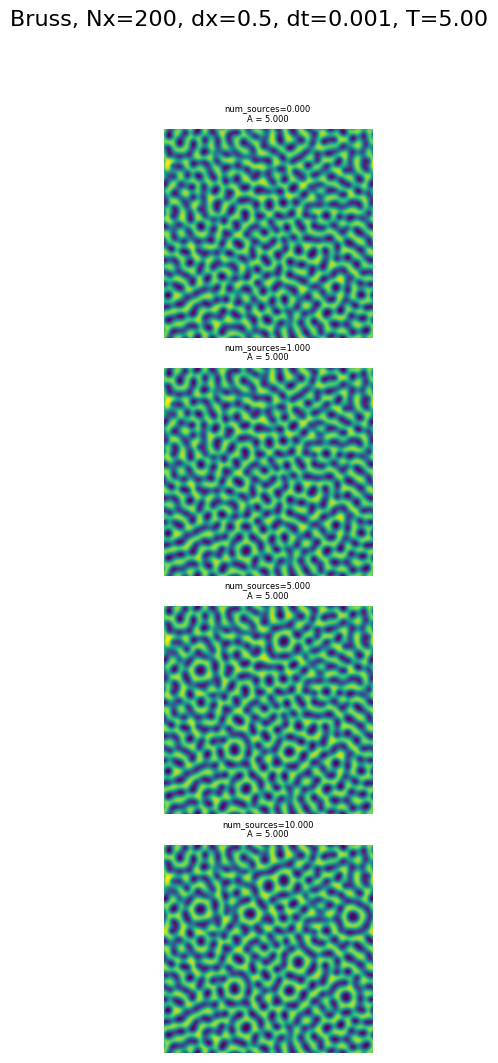

In [12]:
ab_grid(df, 1, frame=-1, sigdigits=3, var1="num_sources", var2="A", file="gray_scott_ab")

In [27]:
ab_grid_animation(df, 1, sigdigits=2, var1="A", var2="B", file="bruss_a_b.gif")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x150696d629d0>>
Traceback (most recent call last):
  File "/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [6]:
def snapshot_grid(df, column, component_idx=0, n_images=5, sigdigits=2):
    df_filtered = df.sort_values(by=column)

    count = len(df_filtered)
    fig = plt.figure(figsize=(20, 24))
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(count, n_images),
        axes_pad=0.5,  # pad between Axes in inch.
    )

    ims = []

    for i, row in df_filtered.iterrows():
        ds = nc.Dataset(row["filename"])
        data = ds.variables["data"][:]
        for j in range(n_images):
            frame_idx = int(row["n_snapshots"] * j / n_images)
            ims.append((j, row, data[0, frame_idx, :, component_idx::2]))
    
    for ax, (j, row, im) in zip(grid, ims):
        if j == 0:
            ax.set_title(f"A={row['A']:.{sigdigits}f} B = {row['B']:.{sigdigits}f}")
        else:
            frame_idx = int(row["n_snapshots"] * j / n_images)
            t = row["dt"] * row["Nt"] / row["n_snapshots"] * frame_idx
            ax.set_title(f"t={t:.{sigdigits}f}")
        ax.imshow(im, cmap="viridis")
        ax.set_aspect("equal")
        ax.axis("off")
    
    plt.show()

In [7]:
# df_a = df[df["A"] == 5.0]
# snapshot_grid(df_a, "A")

In [14]:
def plot(data):
    global_min = np.min(data)
    global_max = np.max(data)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

    # Display the first snapshot initially; this will be updated in the animation
    matrix = data[0, 0, :, 0::2]
    im = ax.imshow(
        matrix, cmap="viridis", aspect="equal", vmin=global_min, vmax=global_max
    )
    return fig, ax, im


In [15]:
def animate(snapshot, coupled_idx, data, im, ax):
    matrix = data[0, snapshot, :, coupled_idx::2]
    im.set_array(matrix)  # Update data for each coupled component
    name = "u" if coupled_idx == 0 else "v"
    # ax.set_title(
    #     f"Snapshot {snapshot + 1}, {name}"
    # )
    return [im]

In [17]:
def make_animation(data, param, out_dir, coupled_idx):
    fig, ax, im = plot(data)
    ani = animation.FuncAnimation(
        fig,
        partial(animate, coupled_idx=coupled_idx, data=data, im=im, ax=ax),
        frames=data.shape[1],
        interval=100,
        blit=True,
    )
    out_name = os.path.join(out_dir, f"{param}_output.gif")
    print(f"Saved to {out_name}")
    ani.save(out_name, writer="ffmpeg", dpi=150)
    plt.close(fig)


In [18]:

row = df.iloc[0]
print(row['A'], row['B'], row['dt'], row['Dv'])
ds = nc.Dataset(row["filename"])
data = ds.variables["data"][:]
make_animation(data, "test", output_dir, coupled_idx=1)

MovieWriter ffmpeg unavailable; using Pillow instead.


0.039 0.054599999999999996 0.01 0.1
Saved to /cluster/scratch/vogtva/out/gray_scott/test_output.gif


In [17]:
for i, row in df.iterrows():
    ds = nc.Dataset(row["filename"])
    data = ds.variables["data"][:]
    A, B = row['A'], row['B']
    make_animation(data, f"GS-{A}-{B}", output_dir)

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailab

In [ ]:
def save_final_frame(data, param, out_dir):
    fig, ax, ims = plot(data)
    animate(data.shape[1] - 1, 1, data, ims, ax)
    plt.savefig(os.path.join(out_dir, f"{param}_final.png"))
    plt.close()


In [26]:
save_final_frame(data, "A5", output_dir)

In [5]:
df = df0
df = df[df['run_id'] == 'gs_vary_ab_single']
df

,model,A,B,Nx,dx,Nt,dt,Du,Dv,sigma_ic,random_seed,n_snapshots,filename,run_id
36,gray_scott,0.037,0.06,400,0.5,10000,0.025,0.2,0.1,0.1,1,100,/cluster/scratch/vogtva/data/gray_scott/019408...,gs_vary_ab_single


In [10]:
for i, row in df.iterrows():
    ds = nc.Dataset(row["filename"])
    data = ds.variables["data"][:]
    A, B = row['A'], row['B']
    make_animation(data, f"GS-{A}-{B}", output_dir)

MovieWriter ffmpeg unavailable; using Pillow instead.
